In [1]:
from pathlib import Path
from functools import partial
from collections import defaultdict
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vision_utils
import lpips
from torchinfo import summary
import torch.distributions as dists
import os
from log_utils import log, load_stats, load_model
import copy
import time
import random
from log_utils import log, log_stats, save_model, save_stats, save_images, save_maps, \
                            display_images, display_maps, set_up_visdom, config_log, start_training_log, log_hparams_to_json
import visdom
from torchinfo import summary
from torchvision.datasets import LSUN
from torch.utils.data import DataLoader, random_split


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0

In [3]:
device

device(type='cuda')

# Datasets

https://github.com/samb-t/unleashing-transformers/blob/master/models/vqgan.py


# Models

## (Autoregressive) Transformer Model

### Causal Self Attention

In [4]:
class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, H):
        super().__init__()
        assert H.bert_n_emb % H.bert_n_head == 0
        # key, query, value projections for all heads
        self.key = nn.Linear(H.bert_n_emb, H.bert_n_emb)
        self.query = nn.Linear(H.bert_n_emb, H.bert_n_emb)
        self.value = nn.Linear(H.bert_n_emb, H.bert_n_emb)
        # regularization
        self.attn_drop = nn.Dropout(H.attn_pdrop)
        self.resid_drop = nn.Dropout(H.resid_pdrop)
        # output projection
        self.proj = nn.Linear(H.bert_n_emb, H.bert_n_emb)
        self.n_head = H.bert_n_head
        self.causal = True if H.sampler == 'autoregressive' else False
        if self.causal:
            block_size = np.prod(H.latent_shape)
            mask = torch.tril(torch.ones(block_size, block_size))
            self.register_buffer("mask", mask.view(1, 1, block_size, block_size))

    def forward(self, x, layer_past=None):
        B, T, C = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)

        present = torch.stack((k, v))
        if self.causal and layer_past is not None:
            past_key, past_value = layer_past
            k = torch.cat((past_key, k), dim=-2)
            v = torch.cat((past_value, v), dim=-2)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))

        if self.causal and layer_past is None:
            att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))

        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        # re-assemble all head outputs side by side
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        # output projection
        y = self.resid_drop(self.proj(y))
        return y, present




### Transformer Block

In [5]:
class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, H):
        super().__init__()
        self.ln1 = nn.LayerNorm(H.bert_n_emb)
        self.ln2 = nn.LayerNorm(H.bert_n_emb)
        self.attn = CausalSelfAttention(H)
        self.mlp = nn.Sequential(
            nn.Linear(H.bert_n_emb, 4 * H.bert_n_emb),
            nn.GELU(),  # nice
            nn.Linear(4 * H.bert_n_emb, H.bert_n_emb),
            nn.Dropout(H.resid_pdrop),
        )

    def forward(self, x, layer_past=None, return_present=False):

        attn, present = self.attn(self.ln1(x), layer_past)
        x = x + attn
        x = x + self.mlp(self.ln2(x))

        if layer_past is not None or return_present:
            return x, present
        return x




### Transformer Model

In [6]:
class Transformer(nn.Module):
    """  the full GPT language model, with a context size of block_size """

    def __init__(self, H):
        super().__init__()

        self.vocab_size = H.codebook_size + 1
        self.n_embd = H.bert_n_emb
        self.block_size = H.block_size
        self.n_layers = H.bert_n_layers
        self.codebook_size = H.codebook_size
        self.causal = H.sampler == 'autoregressive'
        if self.causal:
            self.vocab_size = H.codebook_size

        self.tok_emb = nn.Embedding(self.vocab_size, self.n_embd)
        self.pos_emb = nn.Parameter(
            torch.zeros(1, self.block_size, self.n_embd))
        self.start_tok = nn.Parameter(torch.zeros(1, 1, self.n_embd))
        self.drop = nn.Dropout(H.embd_pdrop)

        # transformer
        self.blocks = nn.Sequential(*[Block(H) for _ in range(self.n_layers)])
        # decoder head
        self.ln_f = nn.LayerNorm(self.n_embd)
        self.head = nn.Linear(self.n_embd, self.codebook_size, bias=False)

    def get_block_size(self):
        return self.block_size

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, idx, t=None):
        # each index maps to a (learnable) vector
        token_embeddings = self.tok_emb(idx)

        if self.causal:
            token_embeddings = torch.cat(
                (self.start_tok.repeat(token_embeddings.size(0), 1, 1), token_embeddings),
                dim=1
            )

        t = token_embeddings.shape[1]
        # print(f'token embeddings shape: {token_embeddings.shape}')
        assert t <= self.block_size, "Cannot forward, model block size is exhausted."
        # each position maps to a (learnable) vector

        position_embeddings = self.pos_emb[:, :t, :]

        x = token_embeddings + position_embeddings
        x = self.drop(x)
        for block in self.blocks:
            x = block(x)
        x = self.ln_f(x)
        logits = self.head(x)

        return logits

## Absorbing Diffusion

### Sampler Module

In [7]:
class Sampler(nn.Module):
    def __init__(self, H, embedding_weight):
        super().__init__()
        self.latent_shape = H.latent_shape
        self.emb_dim = H.emb_dim
        self.codebook_size = H.codebook_size
        self.embedding_weight = embedding_weight
        self.embedding_weight.requires_grad = False
        self.n_samples = H.n_samples

    def train_iter(self, x, x_target, step):
        raise NotImplementedError()

    def sample(self):
        raise NotImplementedError()

    def class_conditional_train_iter(self, x, y):
        raise NotImplementedError()

    def class_conditional_sample(n_samples, y):
        raise NotImplementedError()

    def embed(self, z):
        with torch.no_grad():
            z_flattened = z.view(-1, self.codebook_size)
            print(f'z shape: {z.shape}')
            print(f'z_flattened shape: {z_flattened.shape}')
            print(f'latent shape: {self.latent_shape}')
            embedded = torch.matmul(z_flattened, self.embedding_weight).view(
                z.size(0),
                self.latent_shape[1],  # D
                self.latent_shape[2],  # H 
                self.latent_shape[3],  # W
                self.emb_dim
            ).permute(0, 4, 1, 2, 3).contiguous()

        return embedded

### Absorbing diffusion super model

In [8]:
class AbsorbingDiffusion(Sampler):
    def __init__(self, H, denoise_fn, mask_id, embedding_weight, aux_weight=0.01):
        super().__init__(H, embedding_weight=embedding_weight)

        self.num_classes = H.codebook_size
        self.latent_emb_dim = H.emb_dim
        self.shape = tuple(H.latent_shape)
        self.num_timesteps = H.total_steps

        self.mask_id = mask_id
        self._denoise_fn = denoise_fn
        self.n_samples = H.batch_size
        self.loss_type = H.loss_type
        self.mask_schedule = H.mask_schedule
        self.aux_weight = aux_weight
        self.register_buffer('Lt_history', torch.zeros(self.num_timesteps+1))
        self.register_buffer('Lt_count', torch.zeros(self.num_timesteps+1))
        self.register_buffer('loss_history', torch.zeros(self.num_timesteps+1))

        assert self.mask_schedule in ['random', 'fixed']

    def sample_time(self, b, device, method='uniform'):
        if method == 'importance':
            if not (self.Lt_count > 10).all():
                return self.sample_time(b, device, method='uniform')

            Lt_sqrt = torch.sqrt(self.Lt_history + 1e-10) + 0.0001
            Lt_sqrt[0] = Lt_sqrt[1]  # Overwrite decoder term with L1.
            pt_all = Lt_sqrt / Lt_sqrt.sum()

            t = torch.multinomial(pt_all, num_samples=b, replacement=True)

            pt = pt_all.gather(dim=0, index=t)

            return t, pt

        elif method == 'uniform':
            t = torch.randint(1, self.num_timesteps+1, (b,), device=device).long()
            pt = torch.ones_like(t).float() / self.num_timesteps
            return t, pt

        else:
            raise ValueError
        
    def q_sample(self, x_0, t):
        # samples q(x_t | x_0)
        # randomly set token to mask with probability t/T
        x_t, x_0_ignore = x_0.clone(), x_0.clone()

        mask = torch.rand_like(x_t.float()) < (t.float().unsqueeze(-1) / self.num_timesteps)
        x_t[mask] = self.mask_id        #   set random tokens to mask_id
        x_0_ignore[torch.bitwise_not(mask)] = -1    #   set positions that are not masked to -1 - copy of x_0 with -1 where there is no mask
        return x_t, x_0_ignore, mask

    def q_sample_mlm(self, x_0, t):
        # samples q(x_t | x_0)
        # fixed noise schedule, masks exactly int(t/T * latent_size) tokens
        x_t, x_0_ignore = x_0.clone(), x_0.clone()

        mask = torch.zeros_like(x_t).to(torch.bool)

        # TODO: offset so each n_masked_tokens is picked with equal probability
        n_masked_tokens = (t.float() / self.num_timesteps) * x_t.size(1)
        n_masked_tokens = torch.round(n_masked_tokens).to(torch.int64)
        n_masked_tokens[n_masked_tokens == 0] = 1
        ones = torch.ones_like(mask[0]).to(torch.bool).to(x_0.device)

        for idx, n_tokens_to_mask in enumerate(n_masked_tokens):
            index = torch.randperm(x_0.size(1))[:n_tokens_to_mask].to(x_0.device)
            mask[idx].scatter_(dim=0, index=index, src=ones)

        x_t[mask] = self.mask_id
        x_0_ignore[torch.bitwise_not(mask)] = -1
        return x_t, x_0_ignore, mask
    
    def _train_loss(self, x_0):
        b, device = x_0.size(0), x_0.device

        # choose what time steps to compute loss at
        t, pt = self.sample_time(b, device, 'uniform')

        # make x noisy and denoise

        if self.mask_schedule == 'random':
            x_t, x_0_ignore, mask = self.q_sample(x_0=x_0, t=t)
        elif self.mask_schedule == 'fixed':
            x_t, x_0_ignore, mask = self.q_sample_mlm(x_0=x_0, t=t)

        # sample p(x_0 | x_t)
        x_0_hat_logits = self._denoise_fn(x_t, t=t).permute(0, 2, 1)

        # Always compute ELBO for comparison purposes
        cross_entropy_loss = F.cross_entropy(x_0_hat_logits, x_0_ignore, ignore_index=-1, reduction='none').sum(1)
        vb_loss = cross_entropy_loss / t
        vb_loss = vb_loss / pt
        vb_loss = vb_loss / (math.log(2) * x_0.shape[1:].numel())
        if self.loss_type == 'elbo':
            loss = vb_loss
        elif self.loss_type == 'mlm':
            denom = mask.float().sum(1)
            denom[denom == 0] = 1  # prevent divide by 0 errors.
            loss = cross_entropy_loss / denom
        elif self.loss_type == 'reweighted_elbo':
            weight = (1 - (t / self.num_timesteps))
            loss = weight * cross_entropy_loss
            loss = loss / (math.log(2) * x_0.shape[1:].numel())
        else:
            raise ValueError

        # Track loss at each time step history for bar plot
        Lt2_prev = self.loss_history.gather(dim=0, index=t)
        new_loss_history = (0.1 * loss + 0.9 * Lt2_prev).detach().to(self.loss_history.dtype)

        self.loss_history.scatter_(dim=0, index=t, src=new_loss_history)

        # Track loss at each time step for importance sampling
        Lt2 = vb_loss.detach().clone().pow(2)
        Lt2_prev = self.Lt_history.gather(dim=0, index=t)
        new_Lt_history = (0.1 * Lt2 + 0.9 * Lt2_prev).detach().to(self.loss_history.dtype)
        self.Lt_history.scatter_(dim=0, index=t, src=new_Lt_history)
        self.Lt_count.scatter_add_(dim=0, index=t, src=torch.ones_like(Lt2).to(self.loss_history.dtype))

        return loss.mean(), vb_loss.mean()

    def sample(self, temp=1.0, sample_steps=None):
        b, device = self.n_samples, 'cuda'
        x_t = torch.ones((b, np.prod(self.shape)), device=device).long() * self.mask_id     #   initialize x_t to be an array with all mask_ids
        unmasked = torch.zeros_like(x_t, device=device).bool()     #   initialize unmasked to be an array of all False . This keeps track of which elements have been unmasked
        sample_steps = list(range(1, sample_steps+1))    #   sample_steps is a list of integers from 1 to sample_steps

        for t in reversed(sample_steps):
            print(f'Sample timestep {t:4d}', end='\r')
            t = torch.full((b,), t, device=device, dtype=torch.long)    #   set t to be an array of the current timestep for each sample

            # where to unmask
            #   create an array of random numbers between 0 and 1 for each element in x_t
            #   if the random number is less than 1/t, then the element is unmasked
            changes = torch.rand(x_t.shape, device=device) < 1/t.float().unsqueeze(-1)  
            # don't unmask somewhere already unmasked
            #   create an array of changes that are already unmasked
            #   this is done by performing a bitwise XOR on changes and unmasked
            changes = torch.bitwise_xor(changes, torch.bitwise_and(changes, unmasked))
            # update mask with changes
            #   update the unmasked array with the pixels that will be unmasked this timestep (either already unmasked or newly unmasked)
            unmasked = torch.bitwise_or(unmasked, changes)

            #   Use our denoiser to predict the original input from our noisy input x_t. This x_t is being updated each iteration
            x_0_logits = self._denoise_fn(x_t, t=t)
            # scale by temperature
            x_0_logits = x_0_logits / temp
            #       Create a categorical distribution over from the logits
            x_0_dist = dists.Categorical(
                logits=x_0_logits)
            #       Sample from the distribution. Get predicted x_0 by sampling from the logits distribution (dist over which token is most likely)
            x_0_hat = x_0_dist.sample().long()
            #       Update x_t with the sampled values at the positions we are unmasking
            x_t[changes] = x_0_hat[changes]

        return x_t

    def sample_mlm(self, temp=1.0, sample_steps=None):
        b, device = self.n_samples, 'cuda'
        x_0 = torch.ones((b, np.prod(self.shape)), device=device).long() * self.mask_id
        sample_steps = np.linspace(1, self.num_timesteps, num=sample_steps).astype(np.long)

        for t in reversed(sample_steps):
            print(f'Sample timestep {t:4d}', end='\r')
            t = torch.full((b,), t, device=device, dtype=torch.long)
            x_t, _, _ = self.q_sample(x_0, t)
            x_0_logits = self._denoise_fn(x_t, t=t)
            # scale by temperature
            x_0_logits = x_0_logits / temp
            x_0_dist = dists.Categorical(
                logits=x_0_logits)
            x_0_hat = x_0_dist.sample().long()
            x_0[x_t == self.mask_id] = x_0_hat[x_t == self.mask_id]

        return x_0

    @torch.no_grad()
    def elbo(self, x_0):
        b, device = x_0.size(0), x_0.device
        elbo = 0.0
        for t in reversed(list(range(1, self.num_timesteps+1))):
            print(f'Sample timestep {t:4d}', end='\r')
            t = torch.full((b,), t, device=device, dtype=torch.long)
            x_t, x_0_ignore, _ = self.q_sample(x_0=x_0, t=t)
            x_0_hat_logits = self._denoise_fn(x_t, t=t).permute(0, 2, 1)
            cross_entropy_loss = F.cross_entropy(x_0_hat_logits, x_0_ignore, ignore_index=-1, reduction='none').sum(1)
            elbo += cross_entropy_loss / t
        return elbo

    def train_iter(self, x):
        loss, vb_loss = self._train_loss(x)
        stats = {'loss': loss, 'vb_loss': vb_loss}
        return stats

    # def sample_shape(self, shape, num_samples, time_steps=1000, step=1, temp=0.8):
    #     device = 'cuda'
    #     x_t = torch.ones((num_samples,) + shape, device=device).long() * self.mask_id
    #     x_lim, y_lim = shape[0] - self.shape[1], shape[1] - self.shape[2]

    #     unmasked = torch.zeros_like(x_t, device=device).bool()

    #     autoregressive_step = 0
    #     for t in tqdm(list(reversed(list(range(1, time_steps+1))))):
    #         t = torch.full((num_samples,), t, device='cuda', dtype=torch.long)

    #         unmasking_method = 'autoregressive'
    #         if unmasking_method == 'random':
    #             # where to unmask
    #             changes = torch.rand(x_t.shape, device=device) < 1/t.float().unsqueeze(-1).unsqueeze(-1)
    #             # don't unmask somewhere already unmasked
    #             changes = torch.bitwise_xor(changes, torch.bitwise_and(changes, unmasked))
    #             # update mask with changes
    #             unmasked = torch.bitwise_or(unmasked, changes)
    #         elif unmasking_method == 'autoregressive':
    #             changes = torch.zeros(x_t.shape, device=device).bool()
    #             index = (int(autoregressive_step / shape[1]), autoregressive_step % shape[1])
    #             changes[:, index[0], index[1]] = True
    #             unmasked = torch.bitwise_or(unmasked, changes)
    #             autoregressive_step += 1

    #         # keep track of PoE probabilities
    #         x_0_probs = torch.zeros((num_samples,) + shape + (self.codebook_size,), device='cuda')
    #         # keep track of counts
    #         count = torch.zeros((num_samples,) + shape, device='cuda')

    #         # TODO: Monte carlo approximate this instead
    #         for i in range(0, x_lim+1, step):
    #             for j in range(0, y_lim+1, step):
    #                 # collect local noisy area
    #                 x_t_part = x_t[:, i:i+self.shape[1], j:j+self.shape[2]]

    #                 # increment count
    #                 count[:, i:i+self.shape[1], j:j+self.shape[2]] += 1.0

    #                 # flatten
    #                 x_t_part = x_t_part.reshape(x_t_part.size(0), -1)

    #                 # denoise
    #                 x_0_logits_part = self._denoise_fn(x_t_part, t=t)

    #                 # unflatten
    #                 x_0_logits_part = x_0_logits_part.reshape(x_t_part.size(0), self.shape[1], self.shape[2], -1)

    #                 # multiply probabilities
    #                 # for mixture
    #                 x_0_probs[:, i:i+self.shape[1], j:j+self.shape[2]] += torch.softmax(x_0_logits_part, dim=-1)

    #         # Mixture with Temperature
    #         x_0_probs = x_0_probs / x_0_probs.sum(-1, keepdim=True)
    #         C = torch.tensor(x_0_probs.size(-1)).float()
    #         x_0_probs = torch.softmax((torch.log(x_0_probs) + torch.log(C)) / temp, dim=-1)

    #         x_0_dist = dists.Categorical(probs=x_0_probs)
    #         x_0_hat = x_0_dist.sample().long()

    #         # update x_0 where anything has been masked
    #         x_t[changes] = x_0_hat[changes]

    #     return x_t

# Hyperparams

In [9]:
class HparamsBase(dict):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getattr__(self, attr):
        try:
            return self[attr]
        except KeyError:
            return None

    def __setattr__(self, attr, value):
        self[attr] = value

class HparamsAbsorbing(HparamsBase):
    def __init__(self, dataset):

        self.loss_type = "reweighted_elbo"
        self.sample_type = "diffusion"
        self.mask_schedule = "random"
        self.total_steps = 256
        self.sample_steps = 256
        self.attn_pdrop = 0.
        self.embd_pdrop = 0.
        self.resid_pdrop = 0.
        self.temp = 1.0
        self.visdom_port = 8097
        self.quantizer = 'nearest'
        self.train_steps = 250000
        self.steps_per_log = 500
        self.steps_per_display_output = 5000
        self.steps_per_save_output = 5000
        self.steps_per_checkpoint = 25000
        self.sample_type = "diffusion"
        self.sampler = "absorbing"
        super().__init__(dataset)
        if self.dataset == "MNIST":
            self.val_split = 0.1
            self.batch_size = 20
            self.bert_n_emb = 256
            self.bert_n_head = 4
            self.bert_n_layers = 12
            self.block_size = 128
            self.lr = 2e-4
            self.warmup_iters = 10000
            
        elif self.dataset == 'maps':
            self.val_split = 0.1
            self.batch_size = 32
            self.bert_n_emb = 256
            self.bert_n_head = 4
            self.bert_n_layers = 12
            self.block_size = 128
            self.lr = 2e-4
            self.warmup_iters = 10000

        elif self.dataset == 'minecraft':
            self.val_split = 0.1
            self.batch_size = 8
            self.bert_n_emb = 256
            self.bert_n_head = 4
            self.bert_n_layers = 12
            self.block_size = 256
            self.lr = 2e-4
            self.warmup_iters = 10000
            
        elif self.dataset == "churches" or self.dataset == "bedrooms":
            self.batch_size = 20
            self.bert_n_emb = 256
            self.bert_n_head = 4
            self.bert_n_layers = 12
            self.block_size = 256
            self.lr = 2e-4
            self.warmup_iters = 10000

        elif self.dataset == "ffhq":
            self.batch_size = 20
            self.bert_n_emb = 512
            self.bert_n_head = 8
            self.bert_n_layers = 24
            self.block_size = 512
            self.lr = 1e-4
            self.warmup_iters = 30000

        else:
            raise KeyError(f"Defaults not defined for multinomial diffusion model on dataset: {self.dataset}")


# TODO: properly configure autoregressive args
class HparamsAutoregressive(HparamsBase):
    def __init__(self, dataset):
        super().__init__(dataset)
        self.attn_pdrop = 0.
        self.embd_pdrop = 0.
        self.resid_pdrop = 0.
        self.temp = 1.0

        if self.dataset == "churches" or "bedrooms":
            self.batch_size = 20
            self.bert_n_emb = 512
            self.bert_n_head = 8
            self.bert_n_layers = 24
            self.block_size = 256
            self.lr = 2e-4
            self.warmup_iters = 10000

        elif self.dataset == "ffhq":
            self.batch_size = 20
            self.bert_n_emb = 512
            self.bert_n_head = 8
            self.bert_n_layers = 24
            self.block_size = 256
            self.lr = 1e-4
            self.warmup_iters = 30000
        else:
            raise KeyError(f"Defaults not defined for BERT model on dataset: {self.dataset}")

In [10]:
from hyperparams import HparamsVQGAN
def load_hparams_from_json(log_dir):
    import json
    import os
    
    json_path = os.path.join(log_dir, 'hparams.json')
    
    if not os.path.exists(json_path):
        raise FileNotFoundError(f"No hparams.json file found in {log_dir}")
    
    with open(json_path, 'r') as f:
        hparams = json.load(f)
    

    
    return hparams

def dict_to_vcqgan_hparams(hparams_dict, dataset=None):
    # Determine which hyperparameter class to use based on the dataset
    if dataset == None:
        dataset = hparams_dict.get('dataset', 'MNIST')  # Default to MNIST if not specified
    
    vq_hyper = HparamsVQGAN(dataset)
    # Set attributes from the dictionary
    for key, value in hparams_dict.items():
        setattr(vq_hyper, key, value)
    
    return vq_hyper


# Load the hyperparameters

In [11]:
vq_vae_dir = 'minecraft39ch_ce_3'
H = HparamsAbsorbing('minecraft')
log('---------------------------------')
log(f'Setting up training for sampler on {H.dataset}')
H.log_dir = 'sampler_minecraft_ema_2'
H.load_dir = 'sampler_minecraft_ema_2'
vis = visdom.Visdom(port=H.visdom_port, env= f"{H.dataset}_{H.log_dir}")



vq_H = dict_to_vcqgan_hparams(load_hparams_from_json(f"../model_logs/{vq_vae_dir}"), 'maps')
H.ae_load_dir = vq_H.log_dir
H.ae_load_step = vq_H.load_step
H.codebook_size = vq_H.codebook_size
H.latent_shape = vq_H.latent_shape
H.img_size = vq_H.img_size
H.emb_dim = vq_H.emb_dim
start_training_log(H)
log_hparams_to_json(H, H.log_dir)

---------------------------------
Setting up training for sampler on minecraft
Using following hparams:
> ae_load_dir: minecraft39ch_ce_3
> ae_load_step: 95000
> attn_pdrop: 0.0
> batch_size: 8
> bert_n_emb: 256
> bert_n_head: 4
> bert_n_layers: 12
> block_size: 256
> codebook_size: 512
> dataset: minecraft
> emb_dim: 256
> embd_pdrop: 0.0
> img_size: 24
> latent_shape: [1, 6, 6, 6]
> load_dir: sampler_minecraft_ema_2
> log_dir: sampler_minecraft_ema_2
> loss_type: reweighted_elbo
> lr: 0.0002
> mask_schedule: random
> quantizer: nearest
> resid_pdrop: 0.0
> sample_steps: 256
> sample_type: diffusion
> sampler: absorbing
> steps_per_checkpoint: 25000
> steps_per_display_output: 5000
> steps_per_log: 500
> steps_per_save_output: 5000
> temp: 1.0
> total_steps: 256
> train_steps: 250000
> val_split: 0.1
> visdom_port: 8097
> warmup_iters: 10000
Hyperparameters logged to ../model_logs/sampler_minecraft_ema_2\hparams.json


In [12]:
vq_H

{'dataset': 'minecraft',
 'base_lr': 4.5e-06,
 'beta': 1.0,
 'diff_aug': False,
 'gumbel_kl_weight': 1e-08,
 'gumbel_straight_through': False,
 'quantizer': 'ema',
 'log_dir': 'minecraft39ch_ce_3',
 'ema_beta': 0.995,
 'ema': False,
 'train_steps': 100000,
 'lr': 4.5e-06,
 'steps_per_checkpoint': 5000,
 'steps_per_display_output': 1000,
 'steps_per_eval': 0,
 'steps_per_log': 250,
 'steps_per_save_output': 1000,
 'visdom_port': 8097,
 'load_step': 95000,
 'load_dir': 'minecraft39ch_ce_3',
 'attn_resolutions': [6],
 'batch_size': 8,
 'ch_mult': [1, 2, 4],
 'codebook_size': 512,
 'disc_layers': 3,
 'disc_weight_max': 1,
 'disc_start_step': 20000,
 'emb_dim': 256,
 'img_size': 24,
 'latent_shape': [1, 6, 6, 6],
 'n_channels': 39,
 'ndf': 64,
 'nf': 64,
 'perceptual_weight': 1.0,
 'res_blocks': 2}

In [118]:
import gc
torch.cuda.empty_cache()
gc.collect()



1833

# Train Loop

In [13]:
from sampler_utils import generate_latent_ids3d, get_latent_loaders, retrieve_autoencoder_components_state_dicts, get_samples3d, latent_ids_to_onehot3d
from models3d import VQAutoEncoder, Generator
from data_utils import get_minecraft_dataloaders, MinecraftVisualizer
from tqdm import tqdm
from log_utils import display_minecraft, save_minecraft

In [14]:
if H.dataset == 'minecraft':
    visualizer = MinecraftVisualizer()
    train_loader, val_loader = get_minecraft_dataloaders(
        '../datasets/minecraft_chunks.npy',
        batch_size=H.batch_size,
        num_workers=0,
        val_split=0.1
    )

Loaded 10205 chunks of size torch.Size([20, 20, 20])
Number of unique block types: 39
unique blocks original: [  5  26  27  29  35  38  40  41  56  60  62  83  84  92  93  95 108 118
 119 120 131 132 138 139 140 166 184 187 192 194 195 204 217 222 227 237
 240 241 251]
unique blocks after: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
Block mapping: {5: 0, 26: 1, 27: 2, 29: 3, 35: 4, 38: 5, 40: 6, 41: 7, 56: 8, 60: 9, 62: 10, 83: 11, 84: 12, 92: 13, 93: 14, 95: 15, 108: 16, 118: 17, 119: 18, 120: 19, 131: 20, 132: 21, 138: 22, 139: 23, 140: 24, 166: 25, 184: 26, 187: 27, 192: 28, 194: 29, 195: 30, 204: 31, 217: 32, 222: 33, 227: 34, 237: 35, 240: 36, 241: 37, 251: 38}
Air block is now index: 0

Dataloader details:
Training samples: 9185
Validation samples: 1020
Batch size: 8
Training batches: 1149
Validation batches: 128


In [20]:
# H.latent_shape = [1, 3, 3, 3]
# vq_H.latent_shape = [1, 3, 3, 3]

In [15]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

latents_fp_suffix = '_flipped' if H.horizontal_flip else ''
latents_filepath = f'latents/{H.dataset}_{H.latent_shape[-1]}_{H.log_dir}_train_latents{latents_fp_suffix}.pt'
# latents_filepath = 'latents/churches_16_churches_test3_train_latents.pt'
print(os.path.exists(latents_filepath))
print(f'latents_filepath: {latents_filepath}')

train_with_validation_dataset = False
if H.steps_per_eval:
    train_with_validation_dataset = True


if not os.path.exists(latents_filepath):
    ae_state_dict = retrieve_autoencoder_components_state_dicts(
        H, ['encoder', 'quantize', 'generator']
    )
    ae = VQAutoEncoder(vq_H)
    ae.load_state_dict(ae_state_dict, strict=False)
    # val_loader will be assigned to None if not training with validation dataest
    # train_loader, val_loader = get_mnist_dataloaders(
    #     batch_size=H.batch_size, 
    #     img_size= H.img_size, 
    #     val_split=H.val_split  # 10% of the data for validation
    # )
    log("Transferring autoencoder to GPU to generate latents...")

    ae = ae.cuda()  # put ae on GPU for generating
    generate_latent_ids3d(H, ae, train_loader, val_loader)
    log("Deleting autoencoder to conserve GPU memory...")
    ae = ae.cpu()
    ae = None

train_latent_loader, val_latent_loader = get_latent_loaders(H, get_validation_loader=train_with_validation_dataset)

quanitzer_and_generator_state_dict = retrieve_autoencoder_components_state_dicts(
    H,
    ['quantize', 'generator'],
    remove_component_from_key=True
)
# print("Keys in quanitzer_and_generator_state_dict:", quanitzer_and_generator_state_dict.keys())
# embedding_weight = quanitzer_and_generator_state_dict.pop(
#     'embedding.weight')
# print(f'embedding weight: {embedding_weight}')
if 'embedding.weight' in quanitzer_and_generator_state_dict:
    embedding_weight = quanitzer_and_generator_state_dict.pop('embedding.weight')
elif 'embedding' in quanitzer_and_generator_state_dict:
    embedding_weight = quanitzer_and_generator_state_dict.pop('embedding')
else:
    raise KeyError("Could not find embedding in state dict")
embedding_weight = embedding_weight.cuda()
generator = Generator(vq_H)

generator.load_state_dict(quanitzer_and_generator_state_dict, strict=False)
generator = generator.cuda()
denoise_fn = Transformer(H).cuda()
sampler = AbsorbingDiffusion(
    H, denoise_fn, H.codebook_size, embedding_weight).cuda()

optim = torch.optim.Adam(sampler.parameters(), lr=H.lr)

# initialise before loading so as not to overwrite loaded stats
losses = np.array([])
val_losses = np.array([])
elbo = np.array([])
val_elbos = np.array([])
mean_losses = np.array([])
start_step = 0
log_start_step = 0

scaler = torch.cuda.amp.GradScaler()
train_iterator = cycle(train_latent_loader)
# val_iterator = cycle(val_latent_loader)

log(f"Sampler params total: {sum(p.numel() for p in sampler.parameters())}")

for step in range(start_step, H.train_steps):
    step_start_time = time.time()

    x = next(train_iterator)
    x = x.cuda()

    if H.amp:
        optim.zero_grad()
        with torch.cuda.amp.autocast():
            stats = sampler.train_iter(x)

        scaler.scale(stats['loss']).backward()
        scaler.step(optim)
        scaler.update()
    else:
        stats = sampler.train_iter(x)

        if torch.isnan(stats['loss']).any():
            log(f'Skipping step {step} with NaN loss')
            continue
        optim.zero_grad()
        stats['loss'].backward()
        optim.step()

    losses = np.append(losses, stats['loss'].item())

    if step % H.steps_per_log == 0:
        step_time_taken = time.time() - step_start_time
        stats['step_time'] = step_time_taken
        mean_loss = np.mean(losses)
        stats['mean_loss'] = mean_loss
        mean_losses = np.append(mean_losses, mean_loss)
        losses = np.array([])

        vis.line(
            np.array([mean_loss]),
            np.array([step]),
            win='loss',
            update=('append' if step > 0 else 'replace'),
            opts=dict(title='Loss')
        )
        log_stats(step, stats)

        if H.sampler == 'absorbing':
            elbo = np.append(elbo, stats['vb_loss'].item())
            vis.bar(
                sampler.loss_history,
                list(range(sampler.loss_history.size(0))),
                win='loss_bar',
                opts=dict(title='loss_bar')
            )
            vis.line(
                np.array([stats['vb_loss'].item()]),
                np.array([step]),
                win='ELBO',
                update=('append' if step > 0 else 'replace'),
                opts=dict(title='ELBO')
            )

    images = None
    if step % H.steps_per_display_output == 0:
        images = get_samples3d(H, generator, sampler)
        if step % H.steps_per_save_output == 0:
            log_dir = "../model_logs/" + H.log_dir + "/images"
            os.makedirs(log_dir, exist_ok=True)
            save_path = f"{log_dir}/samples_{step}.png"
            display_minecraft(vis, visualizer, images, train_loader, 'Samples', f'Samples at step {step}', save_path=save_path)
        else:
            display_minecraft(vis, visualizer, images, train_loader, 'Samples', f'Samples at step {step}')

    # if step % H.steps_per_save_output == 0 and step > 0:
    #     if images is None:
    #         images = get_samples(H, generator, sampler)
    #     if H.dataset == 'maps':
    #         save_maps(images, 'samples', step, H.log_dir, visualizer, H.save_individually)
    #     else:
    #         save_images(images, 'samples', step, H.log_dir, H.save_individually)

    if H.steps_per_eval and step % H.steps_per_eval == 0 and step > 0:
        # calculate validation loss
        valid_loss, valid_elbo, num_samples = 0.0, 0.0, 0
        eval_repeats = 5
        log("Evaluating")
        for _ in tqdm(range(eval_repeats)):
            for x in val_latent_loader:
                with torch.no_grad():
                    stats = sampler.train_iter(x.cuda())
                    valid_loss += stats['loss'].item()
                    if H.sampler == 'absorbing':
                        valid_elbo += stats['vb_loss'].item()
                    num_samples += x.size(0)
        valid_loss = valid_loss / num_samples
        if H.sampler == 'absorbing':
            valid_elbo = valid_elbo / num_samples

        val_losses = np.append(val_losses, valid_loss)
        val_elbos = np.append(val_elbos, valid_elbo)
        vis.line(
            np.array([valid_loss]),
            np.array([step]),
            win='Val_loss',
            update=('append' if step > 0 else 'replace'),
            opts=dict(title='Validation Loss')
        )
        if H.sampler == 'absorbing':
            vis.line(
                np.array([valid_elbo]),
                np.array([step]),
                win='Val_elbo',
                update=('append' if step > 0 else 'replace'),
                opts=dict(title='Validation ELBO')
            )

    if step % H.steps_per_checkpoint == 0:
        save_model(sampler, H.sampler, step, H.log_dir)
        save_model(optim, f'{H.sampler}_optim', step, H.log_dir)


        train_stats = {
            'losses': losses,
            'mean_losses': mean_losses,
            'val_losses': val_losses,
            'elbo': elbo,
            'val_elbos': val_elbos,
            'steps_per_log': H.steps_per_log,
            'steps_per_eval': H.steps_per_eval,
        }
        save_stats(H, train_stats, step)


False
latents_filepath: latents/minecraft_6_sampler_minecraft_ema_2_train_latents.pt
Loading VQGAN from ../model_logs/minecraft39ch_ce_3/saved_models/vqgan_95000.th
resolution: 24, num_resolutions: 3, num_res_blocks: 2, attn_resolutions: [6], in_channels: 256, out_channels: 39, block_in_ch: 256, curr_res: 6
Transferring autoencoder to GPU to generate latents...


100%|██████████| 128/128 [00:02<00:00, 45.83it/s]


Deleting autoencoder to conserve GPU memory...
Loading VQGAN from ../model_logs/minecraft39ch_ce_3/saved_models/vqgan_95000.th
resolution: 24, num_resolutions: 3, num_res_blocks: 2, attn_resolutions: [6], in_channels: 256, out_channels: 39, block_in_ch: 256, curr_res: 6
Sampler params total: 9805824
Step: 0  loss: 1.4803  vb_loss: 9.5256  step_time: 0.0710  mean_loss: 1.4803  
z shape: torch.Size([8, 216, 512])
z_flattened shape: torch.Size([1728, 512])
latent shape: [1, 6, 6, 6]
Saving absorbing to absorbing_0.th
Saving absorbing_optim to absorbing_optim_0.th
Saving stats to ../model_logs/sampler_minecraft_ema_2/saved_stats/stats_0
Step: 500  loss: 1.2362  vb_loss: 8.1916  step_time: 0.0210  mean_loss: 1.3088  
Step: 1000  loss: 1.0805  vb_loss: 6.1182  step_time: 0.0200  mean_loss: 1.1334  
Step: 1500  loss: 0.9936  vb_loss: 6.4368  step_time: 0.0210  mean_loss: 0.9808  
Step: 2000  loss: 0.7414  vb_loss: 5.2096  step_time: 0.0220  mean_loss: 0.9229  
Step: 2500  loss: 1.0248  vb_los

# Testing

In [17]:
# Get a batch of latents and inspect shapes
train_latent_loader, val_latent_loader = get_latent_loaders(H, get_validation_loader=True)

# Get one batch
batch = next(iter(train_latent_loader))
print("Batch type:", type(batch))
print("Batch shape:", batch.shape)

# If batch is a tuple/list, inspect each element
if isinstance(batch, (tuple, list)):
    for i, item in enumerate(batch):
        print(f"Item {i} shape:", item.shape)
        print(f"Item {i} type:", type(item))
        print(f"Item {i} min/max values:", item.min().item(), item.max().item())

# If it's a tensor, get more details
if torch.is_tensor(batch):
    print("\nDetailed tensor info:")
    print("Tensor device:", batch.device)
    print("Tensor dtype:", batch.dtype)
    print("Tensor min/max values:", batch.min().item(), batch.max().item())
    print("Unique values:", torch.unique(batch).tolist())
    
    # Print a small slice of the data
    print("\nFirst few elements:")
    print(batch[0, :10])  # First sample, first 10 elements

Batch type: <class 'torch.Tensor'>
Batch shape: torch.Size([8, 27])

Detailed tensor info:
Tensor device: cpu
Tensor dtype: torch.int64
Tensor min/max values: 2 509
Unique values: [2, 6, 9, 10, 25, 30, 37, 38, 43, 44, 59, 63, 67, 73, 74, 79, 82, 87, 95, 97, 99, 109, 112, 121, 124, 125, 130, 138, 142, 144, 154, 155, 166, 169, 170, 177, 178, 186, 187, 190, 191, 197, 205, 211, 212, 214, 215, 217, 218, 222, 225, 227, 235, 239, 242, 243, 244, 248, 250, 252, 257, 259, 263, 264, 265, 272, 277, 283, 287, 288, 289, 292, 293, 294, 295, 305, 316, 320, 323, 325, 326, 329, 330, 331, 341, 350, 351, 353, 355, 357, 359, 361, 362, 364, 371, 376, 384, 394, 396, 398, 399, 402, 403, 407, 416, 421, 423, 429, 437, 440, 444, 447, 448, 449, 457, 460, 461, 477, 478, 479, 488, 489, 491, 492, 493, 497, 498, 500, 502, 503, 508, 509]

First few elements:
tensor([ 67, 222,  67, 364, 138,  10, 283, 252, 288, 272])


## Super sampling

In [65]:
def sample_shape(sampler, shape, num_samples, time_steps=1000, step=1, temp=0.8):
    device = 'cuda'
    x_t = torch.ones((num_samples,) + shape, device=device).long() * sampler.mask_id
    
    # Calculate sliding window limits
    x_lim = shape[1] - sampler.shape[1]  # Depth
    y_lim = shape[2] - sampler.shape[2]  # Height
    z_lim = shape[3] - sampler.shape[3]  # Width
    
    print(f"Target shape: {shape}")
    print(f"Sampler window shape: {sampler.shape}")
    print(f"Sliding limits - x: {x_lim}, y: {y_lim}, z: {z_lim}")
    print(f"Initial x_t shape: {x_t.shape}")

    unmasked = torch.zeros_like(x_t, device=device).bool()

    autoregressive_step = 0
    for t in tqdm(list(reversed(list(range(1, time_steps+1))))):
        t = torch.full((num_samples,), t, device='cuda', dtype=torch.long)

        # Calculate current position
        d = autoregressive_step // (shape[2] * shape[3])
        h = (autoregressive_step % (shape[2] * shape[3])) // shape[3]
        w = autoregressive_step % shape[3]
        
        changes = torch.zeros(x_t.shape, device=device).bool()
        changes[:, d, h, w] = True
        unmasked = torch.bitwise_or(unmasked, changes)
        autoregressive_step += 1

        x_0_probs = torch.zeros((num_samples,) + shape + (sampler.codebook_size,), device='cuda')
        count = torch.zeros((num_samples,) + shape, device='cuda')

        for i in range(0, x_lim+1, step):
            for j in range(0, y_lim+1, step):
                for k in range(0, z_lim+1, step):
                    # Extract window - remove the extra dimension
                    x_t_part = x_t[:, 
                                 i:i+sampler.shape[1],
                                 j:j+sampler.shape[2],
                                 k:k+sampler.shape[3]]
                    
                    print(f"\nWindow position ({i}, {j}, {k})")
                    print(f"Window shape before squeeze: {x_t_part.shape}")
                    
                    # Remove the extra dimension if it exists
                    if len(x_t_part.shape) == 5:  # If we have an extra dimension
                        x_t_part = x_t_part.squeeze(1)
                    
                    print(f"Window shape after squeeze: {x_t_part.shape}")
                    
                    # Check if window is correct size
                    if x_t_part.shape != (num_samples, sampler.shape[1], sampler.shape[2], sampler.shape[3]):
                        print(f"WARNING: Incorrect window size at position ({i}, {j}, {k})")
                        continue

                    # Flatten
                    x_t_part = x_t_part.reshape(x_t_part.size(0), -1)
                    print(f"Flattened shape: {x_t_part.shape}")

                    # Get predictions
                    x_0_logits_part = sampler._denoise_fn(x_t_part, t=t)
                    print(f"Logits shape: {x_0_logits_part.shape}")

                    # Reshape to match window
                    x_0_logits_part = x_0_logits_part.reshape(
                        num_samples,
                        sampler.shape[1],
                        sampler.shape[2],
                        sampler.shape[3],
                        sampler.codebook_size
                    )
                    
                    # Add to probability tensor
                    x_0_probs[:, 
                             i:i+sampler.shape[1],
                             j:j+sampler.shape[2],
                             k:k+sampler.shape[3]] += torch.softmax(x_0_logits_part, dim=-1)
                    
                    count[:, 
                          i:i+sampler.shape[1],
                          j:j+sampler.shape[2],
                          k:k+sampler.shape[3]] += 1.0

        # Average and normalize probabilities
        x_0_probs = x_0_probs / (count.unsqueeze(-1) + 1e-10)
        x_0_probs = x_0_probs / x_0_probs.sum(-1, keepdim=True)
        
        # Sample from distribution
        x_0_dist = dists.Categorical(probs=x_0_probs)
        x_0_hat = x_0_dist.sample().long()

        # Update current position
        x_t[changes] = x_0_hat[changes]

    return x_t

# Test with smaller number of steps first
desired_shape = (1, 6, 10, 6)  # [B, D, H, W]
result = sample_shape(sampler, desired_shape, num_samples=1, time_steps=10)

Target shape: (1, 6, 10, 6)
Sampler window shape: (1, 6, 6, 6)
Sliding limits - x: 0, y: 4, z: 0
Initial x_t shape: torch.Size([1, 1, 6, 10, 6])


  0%|          | 0/10 [00:00<?, ?it/s]


Window position (0, 0, 0)
Window shape before squeeze: torch.Size([1, 1, 6, 6, 6])
Window shape after squeeze: torch.Size([1, 6, 6, 6])
Flattened shape: torch.Size([1, 216])
Logits shape: torch.Size([1, 216, 512])

Window position (0, 1, 0)
Window shape before squeeze: torch.Size([1, 1, 5, 6, 6])
Window shape after squeeze: torch.Size([1, 5, 6, 6])

Window position (0, 2, 0)
Window shape before squeeze: torch.Size([1, 1, 4, 6, 6])
Window shape after squeeze: torch.Size([1, 4, 6, 6])

Window position (0, 3, 0)
Window shape before squeeze: torch.Size([1, 1, 3, 6, 6])
Window shape after squeeze: torch.Size([1, 3, 6, 6])

Window position (0, 4, 0)
Window shape before squeeze: torch.Size([1, 1, 2, 6, 6])
Window shape after squeeze: torch.Size([1, 2, 6, 6])


ValueError: Expected parameter probs (Tensor of shape (1, 1, 6, 10, 6, 512)) of distribution Categorical(probs: torch.Size([1, 1, 6, 10, 6, 512])) to satisfy the constraint Simplex(), but found invalid values:
tensor([[[[[[2.0967e-04, 9.5196e-05, 4.6880e-05,  ..., 1.1493e-05,
             2.2456e-05, 4.1639e-06],
            [5.9142e-03, 8.5864e-05, 4.7398e-04,  ..., 2.5984e-05,
             9.6894e-04, 2.6348e-05],
            [5.8604e-03, 6.8313e-05, 4.7152e-04,  ..., 2.7644e-05,
             6.9165e-04, 2.4020e-05],
            [1.2230e-02, 1.4917e-04, 4.4655e-04,  ..., 3.5290e-05,
             1.2419e-03, 3.8718e-05],
            [1.0622e-02, 1.2851e-04, 5.6257e-04,  ..., 3.3836e-05,
             5.3989e-04, 1.7545e-05],
            [1.7101e-02, 7.2150e-05, 5.8304e-04,  ..., 1.3154e-05,
             1.2442e-03, 9.1217e-06]],

           [[1.9251e-04, 1.6880e-04, 1.9170e-04,  ..., 2.6630e-04,
             5.8633e-05, 8.6664e-05],
            [2.9420e-03, 2.5907e-04, 1.0343e-03,  ..., 2.8472e-04,
             1.9567e-03, 1.1035e-03],
            [2.6871e-03, 2.6657e-04, 1.3039e-03,  ..., 3.3988e-04,
             2.4445e-03, 9.8315e-04],
            [2.7320e-03, 3.2851e-04, 1.8734e-03,  ..., 4.2946e-04,
             2.0172e-03, 5.9540e-04],
            [5.3300e-03, 3.2080e-04, 1.2844e-03,  ..., 3.5230e-04,
             2.0526e-03, 5.2218e-04],
            [7.4022e-03, 1.6624e-04, 7.6882e-04,  ..., 1.0826e-04,
             2.2850e-03, 2.9791e-04]],

           [[1.4644e-04, 1.8301e-04, 1.0682e-04,  ..., 2.5509e-04,
             3.9217e-05, 1.2820e-04],
            [2.6427e-03, 2.0745e-04, 1.1584e-03,  ..., 3.4850e-04,
             2.4958e-03, 1.5270e-03],
            [1.9463e-03, 1.3974e-04, 2.0873e-03,  ..., 3.3225e-04,
             2.3525e-03, 1.4347e-03],
            [2.8423e-03, 8.7255e-05, 1.5216e-03,  ..., 5.7224e-04,
             2.8694e-03, 1.9239e-03],
            [5.2362e-03, 1.5333e-04, 1.6219e-03,  ..., 3.6537e-04,
             3.2771e-03, 6.9740e-04],
            [9.7122e-03, 4.8999e-05, 1.0513e-03,  ..., 9.7788e-05,
             3.0257e-03, 1.1327e-03]],

           ...,

           [[       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan]],

           [[       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan]],

           [[       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan]]],


          [[[9.7168e-05, 3.0152e-04, 1.3914e-04,  ..., 3.5106e-05,
             4.9149e-05, 2.3849e-05],
            [3.7439e-03, 3.6813e-04, 1.5518e-03,  ..., 3.6536e-05,
             2.3403e-03, 1.2055e-04],
            [7.1925e-03, 3.4103e-04, 2.3316e-03,  ..., 2.9752e-05,
             2.0528e-03, 5.3361e-05],
            [1.3585e-02, 1.5088e-04, 1.8803e-03,  ..., 3.8871e-05,
             2.0009e-03, 9.0768e-05],
            [1.2004e-02, 1.7510e-04, 2.1025e-03,  ..., 3.7124e-05,
             1.0820e-03, 4.2366e-05],
            [1.4198e-02, 1.2706e-04, 1.7363e-03,  ..., 2.7834e-05,
             1.9565e-03, 4.6163e-05]],

           [[1.2343e-04, 4.3953e-04, 3.1348e-04,  ..., 6.4713e-04,
             9.5455e-05, 4.3978e-04],
            [1.7200e-03, 1.7143e-04, 1.9976e-03,  ..., 1.7694e-03,
             2.7486e-03, 1.9175e-03],
            [2.3726e-03, 2.4896e-04, 2.8137e-03,  ..., 1.3001e-03,
             2.6613e-03, 3.4973e-03],
            [2.0926e-03, 2.3680e-04, 5.6387e-03,  ..., 8.3043e-04,
             1.5841e-03, 2.0020e-03],
            [3.8376e-03, 2.8666e-04, 5.2716e-03,  ..., 9.2904e-04,
             1.2696e-03, 1.5416e-03],
            [4.7151e-03, 1.6865e-04, 2.6997e-03,  ..., 5.1455e-04,
             1.7470e-03, 1.3834e-03]],

           [[3.6253e-05, 1.7163e-04, 5.1028e-04,  ..., 3.9687e-04,
             7.9645e-05, 3.9032e-04],
            [9.2770e-04, 1.8162e-04, 6.1833e-03,  ..., 3.8437e-04,
             1.9220e-03, 4.1123e-03],
            [9.1927e-04, 1.3898e-04, 5.5283e-03,  ..., 8.0842e-04,
             1.5820e-03, 1.6871e-03],
            [2.0485e-03, 8.8112e-05, 1.1476e-02,  ..., 1.1284e-03,
             1.0605e-03, 3.9010e-03],
            [2.3140e-03, 1.5500e-04, 1.2671e-02,  ..., 9.8321e-04,
             2.8380e-03, 2.4571e-03],
            [3.7384e-03, 1.1121e-04, 1.0433e-02,  ..., 6.9201e-04,
             4.7151e-03, 6.8249e-03]],

           ...,

           [[       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan]],

           [[       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan]],

           [[       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan]]],


          [[[5.9951e-05, 1.9188e-04, 1.7894e-04,  ..., 3.7479e-05,
             2.7650e-05, 2.3921e-05],
            [2.4563e-03, 2.4039e-04, 1.9647e-03,  ..., 3.8305e-05,
             1.1630e-03, 4.5949e-05],
            [9.7191e-03, 1.7458e-04, 2.0653e-03,  ..., 6.7297e-05,
             1.2209e-03, 5.0925e-05],
            [1.4556e-02, 8.8711e-05, 1.7436e-03,  ..., 5.5038e-05,
             1.8319e-03, 9.5476e-05],
            [1.2395e-02, 1.4955e-04, 3.3573e-03,  ..., 5.5982e-05,
             1.2656e-03, 6.5677e-05],
            [1.4738e-02, 1.7314e-04, 2.3147e-03,  ..., 3.4199e-05,
             1.8040e-03, 3.6291e-05]],

           [[7.9132e-05, 5.8207e-04, 3.4536e-04,  ..., 1.2049e-03,
             1.1875e-04, 3.0456e-04],
            [2.0420e-03, 5.2523e-04, 2.3545e-03,  ..., 9.9701e-04,
             2.4447e-03, 1.6678e-03],
            [6.1541e-03, 1.7610e-04, 4.0403e-03,  ..., 2.9898e-03,
             4.2274e-03, 3.4051e-03],
            [4.5137e-03, 2.3425e-04, 5.9800e-03,  ..., 2.9511e-03,
             2.4794e-03, 2.1482e-03],
            [4.7643e-03, 1.5348e-04, 8.9192e-03,  ..., 1.0822e-03,
             1.7807e-03, 3.9989e-03],
            [6.2735e-03, 3.7955e-04, 5.8793e-03,  ..., 5.6571e-04,
             1.5056e-03, 1.3280e-03]],

           [[2.9424e-05, 3.3025e-04, 3.3761e-04,  ..., 3.2138e-04,
             8.2689e-05, 7.1134e-04],
            [2.1300e-03, 1.3111e-04, 3.6695e-03,  ..., 9.0911e-04,
             1.7015e-03, 1.7353e-03],
            [1.8097e-03, 9.9850e-05, 8.8631e-03,  ..., 9.7468e-04,
             1.4200e-03, 1.6902e-03],
            [1.0735e-03, 2.5568e-05, 6.9973e-03,  ..., 2.2133e-03,
             1.3648e-03, 1.9057e-03],
            [2.5086e-03, 9.8774e-05, 1.6837e-02,  ..., 9.6113e-04,
             1.5168e-03, 1.9079e-03],
            [4.1989e-03, 9.3110e-05, 2.6260e-02,  ..., 7.3564e-04,
             2.7540e-03, 4.0426e-03]],

           ...,

           [[       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan]],

           [[       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan]],

           [[       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan]]],


          [[[1.1231e-04, 2.9070e-04, 1.5904e-04,  ..., 2.9744e-05,
             4.6737e-05, 3.4803e-05],
            [3.1346e-03, 2.5706e-04, 1.4478e-03,  ..., 6.5306e-05,
             9.7740e-04, 7.6233e-05],
            [1.0236e-02, 1.8636e-04, 1.5904e-03,  ..., 6.7885e-05,
             1.6003e-03, 5.0230e-05],
            [2.0388e-02, 1.2747e-04, 2.0143e-03,  ..., 1.1381e-04,
             1.8188e-03, 1.1372e-04],
            [1.9106e-02, 2.5319e-04, 2.1668e-03,  ..., 6.2115e-05,
             1.6355e-03, 9.2681e-05],
            [1.9048e-02, 1.9721e-04, 1.4672e-03,  ..., 4.7602e-05,
             2.4725e-03, 6.5740e-05]],

           [[6.4454e-05, 8.3150e-04, 4.6931e-04,  ..., 8.6668e-04,
             1.0255e-04, 2.1562e-04],
            [3.0880e-03, 6.1549e-04, 2.5411e-03,  ..., 2.8319e-03,
             4.6783e-03, 1.4480e-03],
            [4.2557e-03, 1.3123e-03, 4.4323e-03,  ..., 1.2167e-03,
             2.8279e-03, 2.9171e-03],
            [5.3804e-03, 1.4332e-04, 8.6696e-03,  ..., 1.2393e-03,
             2.1683e-03, 5.0111e-03],
            [6.7404e-03, 4.5064e-04, 5.4375e-03,  ..., 3.5482e-03,
             2.7702e-03, 1.7488e-03],
            [7.4373e-03, 4.1976e-04, 3.5537e-03,  ..., 5.7083e-04,
             1.6863e-03, 2.7842e-03]],

           [[4.7702e-05, 2.6205e-04, 8.2361e-04,  ..., 6.9572e-04,
             1.5983e-04, 4.8984e-04],
            [7.3861e-04, 1.6223e-04, 5.8943e-03,  ..., 1.0971e-03,
             1.7839e-03, 2.4863e-03],
            [1.0258e-03, 1.8739e-04, 1.3203e-02,  ..., 8.3877e-04,
             1.7765e-03, 2.0250e-03],
            [2.9620e-03, 2.8847e-04, 1.7802e-02,  ..., 1.1824e-03,
             3.4891e-03, 1.2403e-03],
            [2.6967e-03, 4.6054e-04, 1.0276e-02,  ..., 1.6307e-03,
             2.9733e-03, 1.5640e-03],
            [3.7613e-03, 2.2759e-04, 1.8913e-02,  ..., 6.8799e-04,
             4.3138e-03, 5.3829e-03]],

           ...,

           [[       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan]],

           [[       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan]],

           [[       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan]]],


          [[[5.2830e-05, 6.3419e-04, 2.0775e-04,  ..., 1.7700e-05,
             2.9231e-05, 1.2986e-05],
            [1.3551e-03, 1.3585e-03, 1.4900e-03,  ..., 3.4888e-05,
             1.0960e-03, 6.4270e-05],
            [5.3512e-03, 3.5284e-03, 1.4979e-03,  ..., 5.2437e-05,
             1.2218e-03, 8.3269e-05],
            [9.0251e-03, 1.0718e-03, 1.6696e-03,  ..., 6.5785e-05,
             2.0714e-03, 1.9366e-04],
            [1.3222e-02, 1.6680e-03, 2.2526e-03,  ..., 4.7326e-05,
             1.9963e-03, 9.7159e-05],
            [9.5400e-03, 5.5447e-04, 2.5490e-03,  ..., 2.1792e-05,
             1.5970e-03, 6.0107e-05]],

           [[8.1829e-05, 2.2000e-03, 3.7706e-04,  ..., 3.0906e-04,
             1.2138e-04, 3.4506e-04],
            [1.3080e-03, 1.4287e-03, 2.9550e-03,  ..., 1.2478e-03,
             2.5901e-03, 1.6821e-03],
            [2.5133e-03, 2.1073e-03, 3.3665e-03,  ..., 9.1015e-04,
             2.4865e-03, 3.5382e-03],
            [2.7620e-03, 3.6028e-03, 3.5429e-03,  ..., 2.3635e-03,
             1.7332e-03, 1.1148e-03],
            [6.4042e-03, 5.0983e-03, 5.8883e-03,  ..., 1.4341e-03,
             4.0981e-03, 1.7910e-03],
            [5.2276e-03, 2.7181e-04, 4.7353e-03,  ..., 6.8114e-04,
             2.0920e-03, 4.2618e-03]],

           [[4.8019e-05, 5.1693e-04, 6.3837e-04,  ..., 3.6988e-04,
             1.9991e-04, 9.5364e-04],
            [9.5441e-04, 2.2305e-04, 6.7027e-03,  ..., 8.3729e-04,
             2.5335e-03, 2.7714e-03],
            [2.0709e-03, 1.8330e-04, 1.0748e-02,  ..., 9.1075e-04,
             1.1464e-03, 1.9141e-03],
            [6.7938e-04, 8.3885e-05, 8.8408e-03,  ..., 1.3259e-03,
             1.6363e-03, 3.1735e-03],
            [2.4084e-03, 2.6426e-04, 1.5358e-02,  ..., 1.2281e-03,
             1.9355e-03, 3.2088e-03],
            [2.3151e-03, 3.2011e-04, 1.7065e-02,  ..., 6.2061e-04,
             3.1146e-03, 5.4466e-03]],

           ...,

           [[       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan]],

           [[       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan]],

           [[       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan]]],


          [[[2.9006e-06, 1.3448e-03, 4.3863e-04,  ..., 4.4593e-06,
             2.3449e-06, 5.1466e-06],
            [8.2793e-05, 3.3499e-03, 1.9289e-03,  ..., 7.4101e-06,
             5.5960e-05, 4.8834e-05],
            [1.6225e-04, 3.2851e-03, 3.2059e-03,  ..., 1.6928e-05,
             1.4896e-04, 1.1559e-04],
            [2.3669e-04, 4.8628e-03, 2.5127e-03,  ..., 9.7095e-06,
             9.1899e-05, 6.0865e-05],
            [4.6899e-04, 3.3169e-03, 3.7054e-03,  ..., 1.6612e-05,
             1.2708e-04, 1.2876e-04],
            [1.5896e-04, 2.4647e-03, 5.1128e-03,  ..., 4.2485e-06,
             5.2465e-05, 5.7556e-05]],

           [[9.5279e-06, 9.9429e-03, 8.0061e-04,  ..., 1.5801e-04,
             2.3666e-05, 2.3707e-04],
            [6.1639e-05, 9.3406e-03, 4.3290e-03,  ..., 3.2898e-04,
             1.4138e-04, 1.3208e-03],
            [1.2175e-04, 1.8452e-03, 7.4897e-03,  ..., 4.2562e-04,
             2.9875e-04, 4.0281e-03],
            [9.3211e-05, 1.6882e-02, 5.9586e-03,  ..., 4.2113e-04,
             1.3089e-04, 1.4362e-03],
            [9.1638e-05, 2.4185e-03, 6.8005e-03,  ..., 4.4045e-04,
             1.6370e-04, 4.6896e-03],
            [1.0225e-04, 3.7182e-03, 6.1642e-03,  ..., 2.0875e-04,
             7.7032e-05, 2.2500e-03]],

           [[8.0696e-06, 5.0818e-03, 1.3881e-03,  ..., 1.8788e-04,
             2.0542e-05, 5.9172e-04],
            [8.6147e-05, 1.0546e-03, 1.0025e-02,  ..., 3.6793e-04,
             1.6896e-04, 2.6440e-03],
            [5.5510e-05, 1.7990e-03, 1.1379e-02,  ..., 4.9384e-04,
             1.6954e-04, 3.9120e-03],
            [1.0442e-04, 2.7591e-03, 1.1803e-02,  ..., 6.4487e-04,
             6.8153e-05, 2.6443e-03],
            [8.5724e-05, 8.5561e-04, 1.2557e-02,  ..., 8.5505e-04,
             1.5119e-04, 6.2920e-03],
            [1.1074e-04, 3.3998e-03, 1.2065e-02,  ..., 2.8477e-04,
             1.2231e-04, 5.4891e-03]],

           ...,

           [[       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan]],

           [[       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan]],

           [[       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan],
            [       nan,        nan,        nan,  ...,        nan,
                    nan,        nan]]]]]], device='cuda:0',
       grad_fn=<DivBackward0>)

In [102]:
def sample_shape(sampler, shape, num_samples, time_steps=1000, step=1, temp=0.8):
    device = 'cuda'
    x_t = torch.ones((num_samples,) + shape, device=device).long() * sampler.mask_id
    x_lim = shape[0] - sampler.shape[1]  # Depth
    y_lim = shape[1] - sampler.shape[2]  # Height
    z_lim = shape[2] - sampler.shape[3]  # Width
    # print(f"Target shape: {shape}")
    # print(f"Sampler window shape: {sampler.shape}")
    # print(f"Sliding limits - x: {x_lim}, y: {y_lim}, z: {z_lim}")

    unmasked = torch.zeros_like(x_t, device=device).bool()

    autoregressive_step = 0
    for t in tqdm(list(reversed(list(range(1, time_steps+1))))):
        t = torch.full((num_samples,), t, device='cuda', dtype=torch.long)

        unmasking_method = 'autoregressive'
        changes = torch.zeros(x_t.shape, device=device).bool()
        d = autoregressive_step // (shape[1] * shape[2])  # Move to next depth after H*W steps
        h = (autoregressive_step % (shape[1] * shape[2])) // shape[2]  # Move to next height after W steps
        w = autoregressive_step % shape[2]  # Move through width first
        index = (d, h, w)
        # print(f'index: {index}')
        # print(f'changes: {changes.shape}')
        changes[:, index[0], index[1], index[2]] = True
        unmasked = torch.bitwise_or(unmasked, changes)
        autoregressive_step += 1

        # keep track of PoE probabilities
        x_0_probs = torch.zeros((num_samples,) + shape + (sampler.codebook_size,), device='cuda')
        x_0_probs = x_0_probs.squeeze(1)
        # print(f"Initial x_0_probs shape: {x_0_probs.shape}")
        # keep track of counts
        count = torch.zeros((num_samples,) + shape, device='cuda')

        # TODO: Monte carlo approximate this instead
        for i in range(0, x_lim+1, step):
            for j in range(0, y_lim+1, step):
                for k in range(0, z_lim+1, step):  # Added: Loop over z dimension
                    # collect local noisy area
                    x_t_part = x_t[:, 
                                    i:i+sampler.shape[1],
                                    j:j+sampler.shape[2],
                                    k:k+sampler.shape[3]]
                    
                    # print(x_t_part.shape)
                    # print(f"\nWindow position ({i}, {j}, {k})")
                    # print(f"Window shape before squeeze: {x_t_part.shape}")
                    # increment count
                    count[:, 
                         i:i+sampler.shape[1],
                         j:j+sampler.shape[2],
                         k:k+sampler.shape[3]] += 1.0

                    # flatten
                    x_t_part = x_t_part.reshape(x_t_part.size(0), -1)
                    # print(f'x_t_part flattened shape {x_t_part.shape}')
                    # denoise
                    x_0_logits_part = sampler._denoise_fn(x_t_part, t=t)
                    # print(f'x_0_logits_part.shape {x_t_part.shape}')
                    # unflatten
                    # Fixed: Reshape to 3D
                    x_0_logits_part = x_0_logits_part.reshape(
                        x_t_part.size(0),
                        sampler.shape[1],
                        sampler.shape[2],
                        sampler.shape[3],
                        -1
                    )

                    # multiply probabilities
                    # for mixture
                    x_0_probs[:, 
                        i:i+sampler.shape[1],
                        j:j+sampler.shape[2],
                        k:k+sampler.shape[3]] += torch.softmax(x_0_logits_part, dim=-1)

        # Mixture with Temperature
        x_0_probs = x_0_probs / x_0_probs.sum(-1, keepdim=True)
        C = torch.tensor(x_0_probs.size(-1)).float()
        x_0_probs = torch.softmax((torch.log(x_0_probs) + torch.log(C)) / temp, dim=-1)

        x_0_dist = dists.Categorical(probs=x_0_probs)
        x_0_hat = x_0_dist.sample().long()

        # update x_0 where anything has been masked
        x_t[changes] = x_0_hat[changes]

    return x_t



100%|██████████| 432/432 [00:14<00:00, 28.88it/s]


In [103]:
@torch.no_grad()
def process_super_sampled_latents(latents, sampler, generator, H):
    """
    Convert super-sampled latents to blocks using the generator.
    
    Args:
        latents: The super-sampled latents of shape [D, H, W]
        sampler: The trained sampler model
        generator: The VQGAN generator
        H: Hyperparameters
    
    Returns:
        The generated blocks
    """
    # Add batch dimension if not present
    if len(latents.shape) == 3:
        latents = latents.unsqueeze(0)
    
    print(f"Latents shape: {latents.shape}")
    
    # Convert to one-hot
    latents_one_hot = latent_ids_to_onehot3d(latents, latents.shape, H.codebook_size)
    print(f"One-hot shape: {latents_one_hot.shape}")
    
    # Instead of using sampler.embed, we'll do the embedding manually
    z_flattened = latents_one_hot
    embedded = torch.matmul(z_flattened, sampler.embedding_weight).view(
        latents.size(0),  # Batch
        latents.size(1),  # Depth
        latents.size(2),  # Height
        latents.size(3),  # Width
        sampler.emb_dim   # Embedding dimension
    ).permute(0, 4, 1, 2, 3).contiguous()
    
    print(f"Embedded shape: {embedded.shape}")
    
    # Generate using VQGAN
    images = generator(embedded.float())
    
    return images

# Usage:


Latents shape: torch.Size([1, 12, 6, 6])
One-hot shape: torch.Size([1, 432, 512])
Embedded shape: torch.Size([1, 256, 12, 6, 6])


In [99]:
generated_blocks.shape

torch.Size([1, 39, 24, 40, 24])

In [148]:
torch.cuda.empty_cache()
gc.collect()

1133109

In [143]:
class MinecraftVisualizer2:
    def __init__(self):
        """Initialize the visualizer with the same block color mappings"""
        self.blocks_to_cols = {
            0: (0.5, 0.25, 0.0),    # light brown
            29: "#006400",
            38: "#B8860B",
            60: "brown",
            92: "gold",
            93: "green",
            115: "brown",
            119: "forestgreen",
            120: "forestgreen",
            194: "yellow",
            217: "gray",
            227: "#90EE90",
            240: "blue",
            40: "#2F4F4F",
            62: "#228B22",
            108: "#BEBEBE",
            131: "saddlebrown",
            132: "saddlebrown",
            95: "lightgray",
            243: "wheat",
            197: "limegreen",
            166: "orange",
            167: "#FF8C00",
            184: "#FFA07A",
            195: "tan",
            250: "white",
            251: "gold",
        }

    def visualize_chunk(self, voxels, ax=None):
        """
        Create a 3D visualization of a Minecraft chunk using the original plotting logic.
        
        Args:
            voxels: torch.Tensor [C,H,W,D] (one-hot) or numpy.ndarray [H,W,D] (block IDs)
            ax: Optional matplotlib axis
        """
        # Convert one-hot to block IDs if needed
        if isinstance(voxels, torch.Tensor):
            if voxels.dim() == 4:  # One-hot encoded [C,H,W,D]
                voxels = voxels.detach().cpu()
                voxels = torch.argmax(voxels, dim=0).numpy()
            else:
                voxels = voxels.detach().cpu().numpy()

        # Apply the same transformations as original
        voxels = voxels.transpose(2, 0, 1)
        # Rotate the voxels 90 degrees around the height axis
        voxels = np.rot90(voxels, 1, (0, 1))

        # Get dimensions after rotation
        depth, height, width = voxels.shape
        
        # Calculate scaling factors based on 6x6x6 being the default size
        default_size = 6
        scale_x = depth / default_size
        scale_y = height / default_size
        scale_z = width / default_size
        
        # Create axis if not provided
        if ax is None:
            # Scale figure size based on dimensions
            fig = plt.figure(figsize=(8 * scale_x, 8 * scale_y))
            ax = fig.add_subplot(111, projection='3d')

        # Adjust the axis aspect ratio to match the data dimensions
        ax.set_box_aspect((scale_x, scale_y, scale_z))

        # Plot non-air blocks
        other_vox = (voxels != 5) & (voxels != -1)
        
        # Plot each block type with its color
        for block_id in np.unique(voxels[other_vox]):
            if block_id not in self.blocks_to_cols:
                # print(f"Unknown block id: {block_id}")
                continue
            ax.voxels(voxels == block_id, facecolors=self.blocks_to_cols[int(block_id)])
            other_vox = other_vox & (voxels != block_id)

        # Plot remaining blocks in red with black edges
        ax.voxels(other_vox, edgecolor="k", facecolor="red")
        
        return ax

In [146]:
visualizer2 = MinecraftVisualizer2()

In [149]:
desired_shape = (16, 6, 6)  # Extending in the Y direction
super_sample = sample_shape(sampler, desired_shape, num_samples=2, time_steps=desired_shape[0] * desired_shape[1] * desired_shape[2] )
generated_blocks = process_super_sampled_latents(super_sample, sampler, generator, H)
# Now you can visualize the blocks
display_minecraft(vis, visualizer2, generated_blocks, train_loader, 
                 win_name="super_sampled_result", 
                 title="Super-sampled Minecraft Chunk")

100%|██████████| 576/576 [00:30<00:00, 18.60it/s]


Latents shape: torch.Size([2, 16, 6, 6])
One-hot shape: torch.Size([2, 576, 512])
Embedded shape: torch.Size([2, 256, 16, 6, 6])


In [96]:
generated_blocks = process_super_sampled_latents(super_sample, sampler, generator, H)

z shape: torch.Size([1, 360, 512])
z_flattened shape: torch.Size([360, 512])
latent shape: [1, 6, 6, 6]


RuntimeError: shape '[1, 6, 6, 6, 256]' is invalid for input of size 92160

## Check Map Memorization

Generating maps...


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:01<01:57,  1.19s/it]

  2%|▏         | 2/100 [00:02<01:52,  1.15s/it]

  3%|▎         | 3/100 [00:03<01:50,  1.14s/it]

  4%|▍         | 4/100 [00:04<01:48,  1.13s/it]

  5%|▌         | 5/100 [00:05<01:47,  1.13s/it]

  6%|▌         | 6/100 [00:06<01:51,  1.18s/it]

  7%|▋         | 7/100 [00:08<01:53,  1.22s/it]

  8%|▊         | 8/100 [00:09<01:54,  1.24s/it]

  9%|▉         | 9/100 [00:10<01:54,  1.25s/it]

 10%|█         | 10/100 [00:12<01:54,  1.27s/it]

 11%|█         | 11/100 [00:13<01:52,  1.26s/it]

 12%|█▏        | 12/100 [00:14<01:48,  1.23s/it]

 13%|█▎        | 13/100 [00:15<01:44,  1.20s/it]

 14%|█▍        | 14/100 [00:16<01:41,  1.18s/it]

 15%|█▌        | 15/100 [00:18<01:41,  1.19s/it]

 16%|█▌        | 16/100 [00:19<01:40,  1.19s/it]

 17%|█▋        | 17/100 [00:20<01:38,  1.18s/it]

 18%|█▊        | 18/100 [00:21<01:37,  1.19s/it]

 19%|█▉        | 19/100 [00:22<01:34,  1.17s/it]

 20%|██        | 20/100 [00:23<01:33,  1.17s/it]

 21%|██        | 21/100 [00:25<01:31,  1.16s/it]

 22%|██▏       | 22/100 [00:26<01:31,  1.17s/it]

 23%|██▎       | 23/100 [00:27<01:29,  1.17s/it]

 24%|██▍       | 24/100 [00:28<01:28,  1.16s/it]

 25%|██▌       | 25/100 [00:29<01:27,  1.16s/it]

 26%|██▌       | 26/100 [00:30<01:26,  1.16s/it]

 27%|██▋       | 27/100 [00:32<01:25,  1.17s/it]

 28%|██▊       | 28/100 [00:33<01:25,  1.19s/it]

 29%|██▉       | 29/100 [00:34<01:25,  1.21s/it]

 30%|███       | 30/100 [00:35<01:25,  1.22s/it]

 31%|███       | 31/100 [00:37<01:25,  1.24s/it]

 32%|███▏      | 32/100 [00:38<01:24,  1.25s/it]

 33%|███▎      | 33/100 [00:39<01:24,  1.25s/it]

 34%|███▍      | 34/100 [00:40<01:23,  1.26s/it]

 35%|███▌      | 35/100 [00:42<01:21,  1.25s/it]

 36%|███▌      | 36/100 [00:43<01:19,  1.25s/it]

 37%|███▋      | 37/100 [00:44<01:18,  1.25s/it]

 38%|███▊      | 38/100 [00:45<01:17,  1.26s/it]

 39%|███▉      | 39/100 [00:47<01:17,  1.27s/it]

 40%|████      | 40/100 [00:48<01:15,  1.26s/it]

 41%|████      | 41/100 [00:49<01:12,  1.23s/it]

 42%|████▏     | 42/100 [00:50<01:09,  1.20s/it]

 43%|████▎     | 43/100 [00:51<01:08,  1.19s/it]

 44%|████▍     | 44/100 [00:53<01:06,  1.19s/it]

 45%|████▌     | 45/100 [00:54<01:13,  1.34s/it]

 46%|████▌     | 46/100 [00:56<01:20,  1.48s/it]

 47%|████▋     | 47/100 [00:58<01:24,  1.59s/it]

 48%|████▊     | 48/100 [01:00<01:26,  1.67s/it]

 49%|████▉     | 49/100 [01:02<01:26,  1.70s/it]

 50%|█████     | 50/100 [01:03<01:28,  1.77s/it]

 51%|█████     | 51/100 [01:06<01:30,  1.86s/it]

 52%|█████▏    | 52/100 [01:08<01:32,  1.92s/it]

 53%|█████▎    | 53/100 [01:10<01:32,  1.96s/it]

 54%|█████▍    | 54/100 [01:12<01:32,  2.00s/it]

 55%|█████▌    | 55/100 [01:14<01:30,  2.02s/it]

 56%|█████▌    | 56/100 [01:16<01:29,  2.03s/it]

 57%|█████▋    | 57/100 [01:18<01:26,  2.02s/it]

 58%|█████▊    | 58/100 [01:20<01:22,  1.96s/it]

 59%|█████▉    | 59/100 [01:22<01:18,  1.92s/it]

 60%|██████    | 60/100 [01:23<01:15,  1.89s/it]

 61%|██████    | 61/100 [01:25<01:13,  1.88s/it]

 62%|██████▏   | 62/100 [01:27<01:12,  1.92s/it]

 63%|██████▎   | 63/100 [01:29<01:12,  1.97s/it]

 64%|██████▍   | 64/100 [01:31<01:12,  2.00s/it]

 65%|██████▌   | 65/100 [01:33<01:10,  2.03s/it]

 66%|██████▌   | 66/100 [01:36<01:09,  2.05s/it]

 67%|██████▋   | 67/100 [01:38<01:07,  2.06s/it]

 68%|██████▊   | 68/100 [01:40<01:06,  2.06s/it]

 69%|██████▉   | 69/100 [01:42<01:04,  2.07s/it]

 70%|███████   | 70/100 [01:44<01:01,  2.06s/it]

 71%|███████   | 71/100 [01:46<00:59,  2.07s/it]

 72%|███████▏  | 72/100 [01:48<00:57,  2.06s/it]

 73%|███████▎  | 73/100 [01:50<00:54,  2.03s/it]

 74%|███████▍  | 74/100 [01:52<00:52,  2.01s/it]

 75%|███████▌  | 75/100 [01:54<00:49,  1.99s/it]

 76%|███████▌  | 76/100 [01:56<00:47,  1.98s/it]

 77%|███████▋  | 77/100 [01:58<00:45,  1.98s/it]

 78%|███████▊  | 78/100 [02:00<00:42,  1.93s/it]

 79%|███████▉  | 79/100 [02:01<00:39,  1.90s/it]

 80%|████████  | 80/100 [02:03<00:37,  1.89s/it]

 81%|████████  | 81/100 [02:05<00:35,  1.88s/it]

 82%|████████▏ | 82/100 [02:07<00:33,  1.87s/it]

 83%|████████▎ | 83/100 [02:09<00:31,  1.85s/it]

 84%|████████▍ | 84/100 [02:11<00:29,  1.84s/it]

 85%|████████▌ | 85/100 [02:12<00:27,  1.83s/it]

 86%|████████▌ | 86/100 [02:14<00:25,  1.86s/it]

 87%|████████▋ | 87/100 [02:16<00:24,  1.87s/it]

 88%|████████▊ | 88/100 [02:18<00:22,  1.90s/it]

 89%|████████▉ | 89/100 [02:20<00:20,  1.89s/it]

 90%|█████████ | 90/100 [02:22<00:19,  1.91s/it]

 91%|█████████ | 91/100 [02:24<00:17,  1.90s/it]

 92%|█████████▏| 92/100 [02:26<00:15,  1.89s/it]

 93%|█████████▎| 93/100 [02:28<00:13,  1.87s/it]

 94%|█████████▍| 94/100 [02:29<00:11,  1.87s/it]

 95%|█████████▌| 95/100 [02:31<00:09,  1.86s/it]

 96%|█████████▌| 96/100 [02:33<00:07,  1.85s/it]

 97%|█████████▋| 97/100 [02:35<00:05,  1.84s/it]

 98%|█████████▊| 98/100 [02:37<00:03,  1.85s/it]

 99%|█████████▉| 99/100 [02:39<00:01,  1.84s/it]

100%|██████████| 100/100 [02:40<00:00,  1.61s/it]


Processing training data...
Generated map shape: torch.Size([10, 10])
Training map shape: (10, 10)
Finding closest matches...


100%|██████████| 100/100 [00:10<00:00,  9.40it/s]


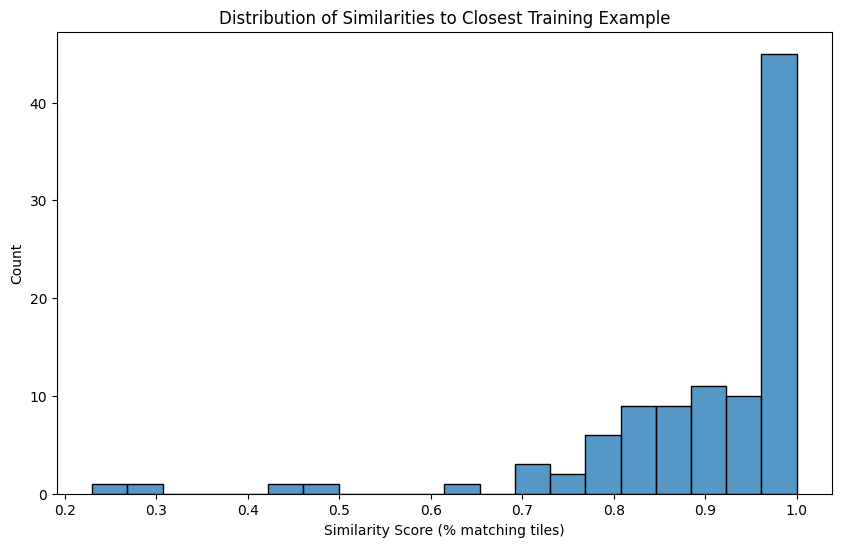


Similarity Statistics:
Mean similarity: 0.895
Median similarity: 0.940
Min similarity: 0.230
Max similarity: 1.000

Visualizing examples...


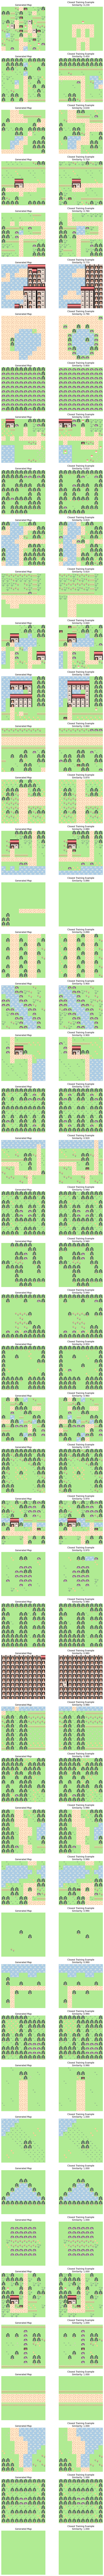

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def calculate_similarity(map1, map2):
    """
    Calculate similarity between two maps.
    Returns percentage of matching tiles (0-1).
    """
    if isinstance(map1, torch.Tensor):
        map1 = map1.cpu().numpy()
    if isinstance(map2, torch.Tensor):
        map2 = map2.cpu().numpy()
    
    return np.mean(map1 == map2)

def analyze_map_memorization(generator, sampler, train_dataset, num_samples=100):
    """
    Generate maps and analyze their similarity to training data.
    
    Args:
        generator: Trained generator model
        sampler: Trained sampler model
        train_dataset: Dataset containing training maps
        num_samples: Number of maps to generate
    """
    # Generate maps
    print("Generating maps...")
    generated_maps = []
    for _ in tqdm(range(num_samples)):
        with torch.no_grad():
            latents = sampler.sample(sample_steps=H.sample_steps, temp=H.temp)
            latents_one_hot = latent_ids_to_onehot(latents, H.latent_shape, H.codebook_size)
            q = sampler.embed(latents_one_hot)
            images = generator(q.float())
            
            # Convert from probabilities to discrete tile indices
            tile_indices = torch.argmax(images, dim=1)  # Shape: [B, H, W]
            generated_maps.append(tile_indices[0])  # Take first (and only) map from batch
    
    # Convert training data to indices
    print("Processing training data...")
    train_maps = []
    for map_data in train_dataset:
        # Convert to tensor if numpy array
        if isinstance(map_data, np.ndarray):
            map_data = torch.from_numpy(map_data)
            
        # Handle different possible formats
        if len(map_data.shape) == 3:  # [C, H, W] or [H, W, C]
            if map_data.shape[-1] == 16:  # [H, W, C]
                map_data = map_data.permute(2, 0, 1)  # Convert to [C, H, W]
            map_data = torch.argmax(map_data, dim=0)  # Convert one-hot to indices
        train_maps.append(map_data.cpu().numpy())
    
    print(f"Generated map shape: {generated_maps[0].shape}")
    print(f"Training map shape: {train_maps[0].shape}")
    
    # Find closest training example for each generated map
    print("Finding closest matches...")
    closest_maps = []
    similarities = []
    
    for gen_map in tqdm(generated_maps):
        max_similarity = 0
        closest_map = None
        
        # Compare with each training example
        for train_map in train_maps:
            similarity = calculate_similarity(gen_map, train_map)
            if similarity > max_similarity:
                max_similarity = similarity
                closest_map = train_map
        
        closest_maps.append(closest_map)
        similarities.append(max_similarity)
    
    # Plot similarity distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(similarities, bins=20)
    plt.title('Distribution of Similarities to Closest Training Example')
    plt.xlabel('Similarity Score (% matching tiles)')
    plt.ylabel('Count')
    plt.show()
    
    # Print summary statistics
    print(f"\nSimilarity Statistics:")
    print(f"Mean similarity: {np.mean(similarities):.3f}")
    print(f"Median similarity: {np.median(similarities):.3f}")
    print(f"Min similarity: {np.min(similarities):.3f}")
    print(f"Max similarity: {np.max(similarities):.3f}")
    
    # Visualize some examples
    print("\nVisualizing examples...")
    num_examples = 50
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, 4*num_examples))
    
    for i in range(num_examples):
        # Sort by similarity and get evenly spaced examples
        sorted_indices = np.argsort(similarities)
        idx = sorted_indices[i * len(similarities) // num_examples]
        
        # Plot generated map
        axes[i, 0].imshow(visualizer.map_to_image(generated_maps[idx]))
        axes[i, 0].set_title(f'Generated Map')
        axes[i, 0].axis('off')
        
        # Plot closest training example
        axes[i, 1].imshow(visualizer.map_to_image(closest_maps[idx]))
        axes[i, 1].set_title(f'Closest Training Example\nSimilarity: {similarities[idx]:.3f}')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Run the analysis
analyze_map_memorization(
    generator, 
    sampler, 
    np.load('../datasets/maps_gpt4_aug.npy', allow_pickle=True).item()['images'],
    num_samples=100
)

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid

# Add this function to visualize the noising process
def visualize_noising_process(sampler, latent, num_steps=10):
    """
    Visualize the noising process for a given latent.
    
    Args:
    sampler (AbsorbingDiffusion): The trained sampler
    latent (torch.Tensor): The input latent to visualize (shape: [1, H, W])
    num_steps (int): Number of noising steps to visualize
    """
    plt.figure(figsize=(20, 4))
    
    # Create a colormap for visualization
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i) for i in range(sampler.codebook_size)]
    colors.append((0, 0, 0, 1))  # Add black color for mask token
    
    for i, t in enumerate(np.linspace(1, sampler.num_timesteps, num_steps).astype(int)):
        t_tensor = torch.full((1,), t, device=latent.device, dtype=torch.long)
        noisy_latent, _, _ = sampler.q_sample(latent, t_tensor)
        
        print(noisy_latent.size())
        print(noisy_latent.view(8, -1).size())
        plt.subplot(1, num_steps, i+1)
        plt.imshow(noisy_latent.view(8, -1).squeeze().cpu().numpy(), cmap=plt.matplotlib.colors.ListedColormap(colors))
        plt.title(f"t={t}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Add this function to visualize the denoising process
def visualize_denoising_process(sampler, generator, latent, mask_percentages=[0.1, 0.5, 0.9]):
    """
    Visualize the denoising process for a given latent at different masking percentages.
    
    Args:
    sampler (AbsorbingDiffusion): The trained sampler
    generator (Generator): The trained generator
    latent (torch.Tensor): The input latent to visualize (shape: [1, H, W])
    mask_percentages (list): List of masking percentages to visualize
    """
    plt.figure(figsize=(20, 5 * len(mask_percentages)))
    
    for idx, mask_percentage in enumerate(mask_percentages):
        t = int(mask_percentage * sampler.num_timesteps)
        t_tensor = torch.full((1,), t, device=latent.device, dtype=torch.long)
        
        # Apply noise
        noisy_latent, _, _ = sampler.q_sample(latent, t_tensor)
        
        # Denoise
        denoised_logits = sampler._denoise_fn(noisy_latent, t=t_tensor)
        denoised_latent = torch.argmax(denoised_logits, dim=-1)
        
        # Generate images
        noisy_image = generator(sampler.embed(noisy_latent))
        denoised_image = generator(sampler.embed(denoised_latent))
        original_image = generator(sampler.embed(latent))
        
        # Visualize
        plt.subplot(len(mask_percentages), 3, idx*3 + 1)
        plt.imshow(noisy_image.squeeze().permute(1, 2, 0).cpu().detach().numpy())
        plt.title(f"Noisy ({mask_percentage*100:.0f}% masked)")
        plt.axis('off')
        
        plt.subplot(len(mask_percentages), 3, idx*3 + 2)
        plt.imshow(denoised_image.squeeze().permute(1, 2, 0).cpu().detach().numpy())
        plt.title(f"Denoised ({mask_percentage*100:.0f}% masked)")
        plt.axis('off')
        
        plt.subplot(len(mask_percentages), 3, idx*3 + 3)
        plt.imshow(original_image.squeeze().permute(1, 2, 0).cpu().detach().numpy())
        plt.title("Original")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Add this code after training to visualize the processes
def visualize_processes(H, sampler, generator):
    # Load a batch of latents
    latents_filepath = f'latents/{H.dataset}_{H.latent_shape[-1]}_{H.log_dir}_train_latents{latents_fp_suffix}.pt'
    latents = torch.load(latents_filepath)
    
    # Select a random latent
    random_idx = np.random.randint(0, len(latents))
    latent = latents[random_idx].unsqueeze(0).cuda()
    
    # Visualize noising process
    print("Visualizing noising process...")
    visualize_noising_process(sampler, latent)
    
    # Visualize denoising process
    print("Visualizing denoising process...")
    visualize_denoising_process(sampler, generator, latent)

def visualize_sample_latents(H, generator, sampler, num_samples=5):
    """
    Visualize a sample of training latents.
    
    Args:
    H (HparamsAbsorbing): Hyperparameters
    generator (Generator): The trained generator
    sampler (AbsorbingDiffusion): The trained sampler
    num_samples (int): Number of latents to visualize
    """
    # Load the latents
    train_latent_loader, _ = get_latent_loaders(H, get_validation_loader=False)
    
    # Get a batch of latents
    latents = next(iter(train_latent_loader))
    latents = latents.cuda()
    
    # Ensure we don't exceed the batch size
    num_samples = min(num_samples, latents.size(0))
    latents = latents[:num_samples]
    print(f'latents size: {latents.size()}')
    # # Generate images from latents
    latents_one_hot = latent_ids_to_onehot(latents, [1, 8, 8], H.codebook_size)
    print(f'latents one_hot size: {latents_one_hot.size()}')
    q = sampler.embed(latents_one_hot)
    images = generator(q.float())
    
    # Visualize
    fig, axes = plt.subplots(2, num_samples, figsize=(4*num_samples, 8))
    
    for i in range(num_samples):
        # Plot latent
        axes[0, i].imshow(latents[i].view(8, 8).cpu().numpy(), cmap='tab20')  # Assuming 8x8 latent shape
        axes[0, i].set_title(f"Latent {i+1}")
        axes[0, i].axis('off')
        
        # # Plot generated image
        # axes[1, i].imshow(images[i].permute(1, 2, 0).cpu().detach().numpy())
        # axes[1, i].set_title(f"Generated {i+1}")
        # axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()


# Call the function
# visualize_sample_latents(H, generator, sampler)

# Call the function


In [76]:
print(H.latent_shape)

[1, 16, 16]


In [78]:
print(H.codebook_size)

512


In [80]:
visualize_sample_latents(H, generator, sampler)

latents size: torch.Size([5, 64])
latents one_hot size: torch.Size([5, 64, 512])


RuntimeError: shape '[5, 16, 16, 128]' is invalid for input of size 40960

Visualizing noising process...
torch.Size([1, 64])
torch.Size([8, 8])
torch.Size([1, 64])
torch.Size([8, 8])
torch.Size([1, 64])
torch.Size([8, 8])
torch.Size([1, 64])
torch.Size([8, 8])
torch.Size([1, 64])
torch.Size([8, 8])
torch.Size([1, 64])
torch.Size([8, 8])
torch.Size([1, 64])
torch.Size([8, 8])
torch.Size([1, 64])
torch.Size([8, 8])
torch.Size([1, 64])
torch.Size([8, 8])
torch.Size([1, 64])
torch.Size([8, 8])


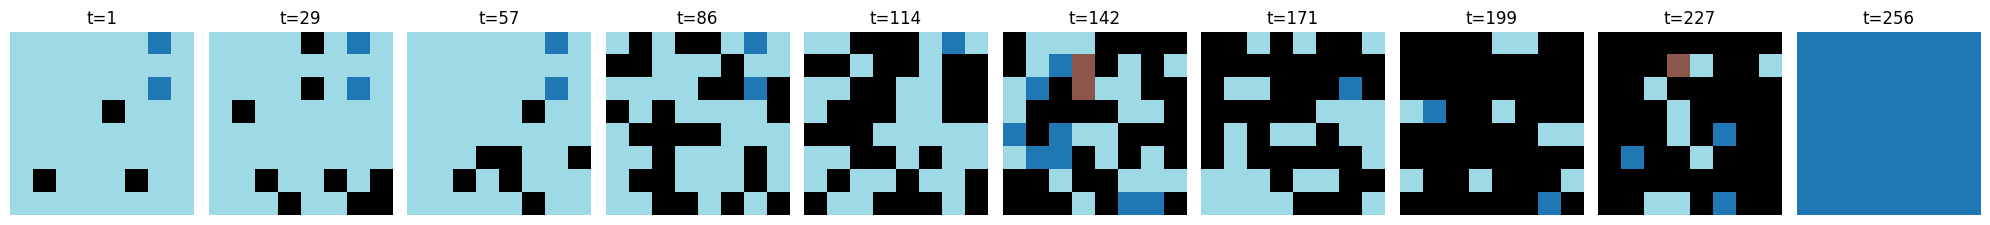

Visualizing denoising process...


RuntimeError: shape '[-1, 512]' is invalid for input of size 64

<Figure size 2000x1500 with 0 Axes>

In [61]:
visualize_processes(H, sampler, generator)

In [22]:
# Load the trained model
sampler_state_dict = torch.load(f'../model_logs/{H.log_dir}/absorbing_75000.th')
# sampler.load_state_dict(sampler_state_dict)

# Run visualizations
visualize_processes(H, sampler, generator)

FileNotFoundError: [Errno 2] No such file or directory: '../model_logs/sampler_churches_test6/absorbing_75000.th'